In [324]:
# import package de base
import os
import warnings
import numpy as np
import pandas as pd

#import package visualisation
import matplotlib.pyplot as plt
import seaborn as sns

import pyforest

#import tests statistiques :
from scipy.stats import chi2_contingency, shapiro, mannwhitneyu, ttest_ind,levene

#import réduction des données
from sklearn.decomposition import PCA

#import preprocessing :
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")

## Jeu de données disponible sur https://www.kaggle.com/competitions/playground-series-s3e24


# Plan :

1. Connaissance du jeu de données:
    - Signification des colonnes et de la problématique  
    - Dimensions (row;col) 
    - type de données (int,..) et vérifier la cohérence (variables continues de préférence en float, discrète en int, etc)
    - Ligne dupliquée ? (ID)
    - Présence d'une target ? 
        - Si oui, classification ou régression ?
            - Si classification : est-ce que les données sont équilibrées ? (Si non -> utilisation du stratify)
2. Imputation des données:
    - Présence de NaN ?
        - Si oui, données manquantes réelle ou absence d'élément ?
    - imputer les données par la moyenne/médiane ou mode en fonction du type de données et de leur répartition

3. Analyse univariée
    - Datavisualisation de chaque features indépendamment
        - Outliers ? Valeurs aberrantes ?
    
4. Analyse bivariée et test statistiques
    - Analyse target Vs variables discrètes : test du khi2
    - Analyse target vs variables continues : vérification de la normalité des features puis mise en place du test student ou man whitney
   
    
5. Analyse multivariée
    - Analyse des variables continues entre elles (heatmap)
    - Analyse des variables corrélées par scatterplot 
    - Analyse des variables anti-corrélées par scatterplot 
    
6. Analyse par PCA 

7. Transformation des données 
    - Encodage et standardisation


# 1. Connaissance du jeu de données 

## objectif :
* La tâche consiste à utiliser la **classification binaire pour prédire le statut tabagique d'un patient** à partir d'informations sur divers autres indicateurs de santé


In [3]:
path = r'D:\Etude_Data_science\Kaggle_competition\02_Binary_Prediction_of_Smoker_Status_using_Bio-Signals\dataset\train.csv'
data = pd.read_csv(path)
df = data.copy()

In [4]:
#Dimension des données
print(f"Le jeu de données est composé de :\n {df.shape[0]} lignes \n {df.shape[1]} colonnes")

Le jeu de données est composé de :
 159256 lignes 
 24 colonnes


In [5]:
df.head()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,0,55,165,60,81.0,0.5,0.6,1,1,135,...,40,75,16.5,1,1.0,22,25,27,0,1
1,1,70,165,65,89.0,0.6,0.7,2,2,146,...,57,126,16.2,1,1.1,27,23,37,1,0
2,2,20,170,75,81.0,0.4,0.5,1,1,118,...,45,93,17.4,1,0.8,27,31,53,0,1
3,3,35,180,95,105.0,1.5,1.2,1,1,131,...,38,102,15.9,1,1.0,20,27,30,1,0
4,4,30,165,60,80.5,1.5,1.0,1,1,121,...,44,93,15.4,1,0.8,19,13,17,0,1


In [6]:
df.sample(5, random_state=42)

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
145654,145654,35,175,80,84.0,0.8,1.0,1,1,122,...,44,96,16.0,1,0.7,31,22,32,0,1
49118,49118,35,185,80,88.0,1.2,1.2,1,1,100,...,49,80,15.0,1,0.9,22,22,17,0,1
21769,21769,20,160,60,76.0,1.2,1.2,1,1,130,...,34,134,16.9,1,0.8,24,32,41,1,1
108299,108299,60,155,60,87.8,0.7,0.2,1,1,119,...,73,167,13.2,1,0.9,21,16,14,0,0
117130,117130,60,165,70,85.0,0.8,0.6,1,1,142,...,49,108,15.5,1,0.7,27,40,61,0,0


In [7]:
df.tail()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
159251,159251,40,155,45,69.0,1.5,2.0,1,1,127,...,72,159,14.5,1,0.8,25,26,13,0,0
159252,159252,50,155,75,82.0,1.0,1.0,1,1,120,...,64,108,14.5,1,0.6,21,20,18,0,0
159253,159253,40,160,50,66.0,1.5,1.0,1,1,114,...,87,93,10.9,1,0.6,15,9,12,0,0
159254,159254,50,165,75,92.0,1.2,1.0,1,1,121,...,55,80,14.4,1,1.1,22,17,37,0,1
159255,159255,40,145,45,76.4,1.0,1.2,1,1,125,...,87,81,14.0,1,0.8,21,16,17,0,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159256 entries, 0 to 159255
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   159256 non-null  int64  
 1   age                  159256 non-null  int64  
 2   height(cm)           159256 non-null  int64  
 3   weight(kg)           159256 non-null  int64  
 4   waist(cm)            159256 non-null  float64
 5   eyesight(left)       159256 non-null  float64
 6   eyesight(right)      159256 non-null  float64
 7   hearing(left)        159256 non-null  int64  
 8   hearing(right)       159256 non-null  int64  
 9   systolic             159256 non-null  int64  
 10  relaxation           159256 non-null  int64  
 11  fasting blood sugar  159256 non-null  int64  
 12  Cholesterol          159256 non-null  int64  
 13  triglyceride         159256 non-null  int64  
 14  HDL                  159256 non-null  int64  
 15  LDL              

In [9]:
df[df.id.duplicated()]

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking


In [220]:
print(f"{df.smoking.value_counts(normalize=True).round(3)*100}")

smoking
0    56.3
1    43.7
Name: proportion, dtype: float64


#### Résumer de 1.
* Jeu de données conséquent avec **23 features** et la présence d'une target **binaire**
    - Les features decrivent les caractéristiques physico-chimique des différents individus avec dosage biochimique de différents lipides tq les TG, HDL, LDL ou encore le cholesterol), dosage de la qté d'oses dans le sang, pression sanguines
    - d'autres mesures à une échelle physiologique ont été effectuées :  poids, tour de taille, taille, la vue pour chaque oeils, l'audition, pression sanguine (systolique et relaxation
    - **AST** : Aspartate-aminotransférase (ou GLUTAMATE-OXALOACETATE-TRANSAMINASE; TGO), **son élévation est le reflet d'une lésion cellulaire** et se rencontre dans les maladies cardiaques
    - **ALT** : Alanine-aminotransférase, Sa libération se rencontre principalement dans les affections hépato-biliaires mais aussi dans **les maladies cardiaques**. Sa libération dans le milieu extra-cellulaire est donc le signe d'une atteinte hépatique, **plus précoce et plus spécifique que la AST**
    - **fasting blood sugar** : glycémie
- Le jeu de données est équilibré selon la target (on reste autour des 50%)
- Lors des analyse univariée des features, il faudra aussi vérifier qu'il n'y ai pas de valeurs aberrantes en se renseignant sur les modalités des différents types de mesures pour chaque éléments

* Il faudra réencoder certaines variables numériques : mettre en float les variables continues et laisser en int les variables discrètes (ex : changer dtypes de age)


#### Transformons les variables dans le bon type et attribuons les dans les bons groupes :
Pour chaque type de variable on va le mettre dans la liste adéquat 

Var_num : contiendra toutes les variables numériques (discrètes + continues)
var_qual : variables qualitatives (ordinale + nominales)

var_cont : variables numérique continues
var_dis : variables numériques discrètes 


var_cat : variables discrètes (qualitatives + discrètes; var_dis+var_qual)

In [10]:
var_num = []
var_dis, var_cont = [],[]
var_qual = []
var_cat = []
var_tot = df.columns

In [11]:
for i in df:
    col = df[i]
    print(f"{i:-<20} : {col.unique()[:5]}  ({col.nunique()} ; {col.dtypes})")


id------------------ : [0 1 2 3 4]  (159256 ; int64)
age----------------- : [55 70 20 35 30]  (18 ; int64)
height(cm)---------- : [165 170 180 160 155]  (14 ; int64)
weight(kg)---------- : [60 65 75 95 55]  (28 ; int64)
waist(cm)----------- : [ 81.   89.  105.   80.5  51. ]  (531 ; float64)
eyesight(left)------ : [0.5 0.6 0.4 1.5 1.2]  (20 ; float64)
eyesight(right)----- : [0.6 0.7 0.5 1.2 1. ]  (17 ; float64)
hearing(left)------- : [1 2]  (2 ; int64)
hearing(right)------ : [1 2]  (2 ; int64)
systolic------------ : [135 146 118 131 121]  (112 ; int64)
relaxation---------- : [87 83 75 88 76]  (75 ; int64)
fasting blood sugar- : [ 94 147  79  91 101]  (229 ; int64)
Cholesterol--------- : [172 194 178 180 155]  (227 ; int64)
triglyceride-------- : [300  55 197 203  87]  (392 ; int64)
HDL----------------- : [40 57 45 38 44]  (108 ; int64)
LDL----------------- : [ 75 126  93 102  99]  (222 ; int64)
hemoglobin---------- : [16.5 16.2 17.4 15.9 15.4]  (134 ; float64)
Urine protein------- : [1 

On va convertir en float :
- age
- height(cm)
- weight(kg)
- systolic
- relaxation,
- fasting blood sugar
- Cholesterol
- triglyceride 
- HDL
- LDL
- AST 
- ALT 
- Gtp 

* A l'exception des variables numériques binaire qui resteront int et  la feature **Urine protein** pouvant prendre **6 valeurs différentes**; toutes les autres variables numériques seront converties en float
* On notera l'absence totale de feature object

In [12]:
#Récupération des variables pouvant prendre au maximum 6 valeurs : 
var_dis = [i for i in df if df[i].nunique()<=6]
#Récupération des variables continues par exclusion des variables discrètes :
#Rq : on exclu l'id des individus car il n'a que pour rôle de différencier chq individus
var_cont = [i for i in df if i not in var_dis and i != "id"]

In [13]:
#Convertissons les variables continues en float :
df[var_cont] = df[var_cont].astype(float)

In [14]:
df.dtypes

id                       int64
age                    float64
height(cm)             float64
weight(kg)             float64
waist(cm)              float64
eyesight(left)         float64
eyesight(right)        float64
hearing(left)            int64
hearing(right)           int64
systolic               float64
relaxation             float64
fasting blood sugar    float64
Cholesterol            float64
triglyceride           float64
HDL                    float64
LDL                    float64
hemoglobin             float64
Urine protein            int64
serum creatinine       float64
AST                    float64
ALT                    float64
Gtp                    float64
dental caries            int64
smoking                  int64
dtype: object

### 2. Imputation des données

In [15]:
df.isnull().sum()

id                     0
age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental caries          0
smoking                0
dtype: int64

Il n'y a aucune données manquantes, donc pas besoin d'imputer les données

### 3. Analyse univariée :
#### Variables discrètes :

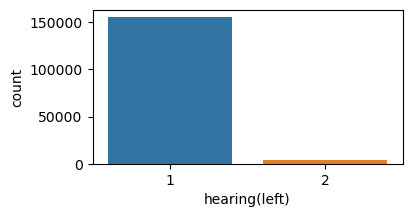

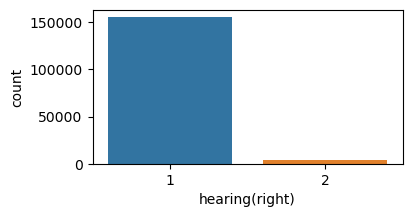

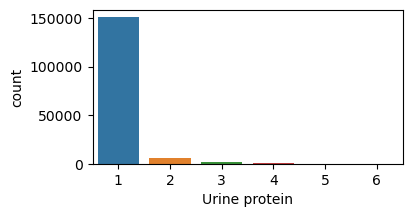

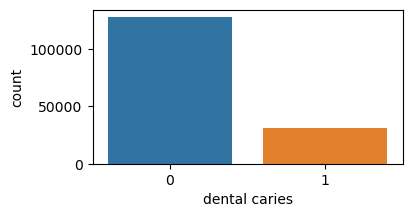

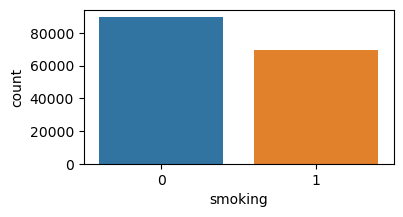

In [16]:
for i in range(len(var_dis)):
    plt.figure(figsize=(4,2))
    sns.countplot(x = var_dis[i], data = df, ) 
#     print(df[var_dis[i]].value_counts())
    plt.show()

#### Variables continues :

In [17]:
def plot_viz(dataframe, columns):
    for i in columns:
        fig,axes = plt.subplots(1,2, figsize=(10,5))

        sns.boxplot(x = i, ax=axes[0],data=dataframe,
                         showmeans=True, color = "yellow",
                         orient="v",
                         meanprops={"marker":"o","markerfacecolor":"red",
                                    "markeredgecolor":"black"} )
        sns.distplot(a=dataframe[i], ax = axes[1])
        axes[1].axvline(dataframe[i].mean(), c = "green", label = "Mean")
        axes[1].axvline(dataframe[i].median(), c = "red", label = "Median")
        axes[1].legend()
        print("Skew", df[i].skew().round(2))
        plt.show()

Skew 0.29


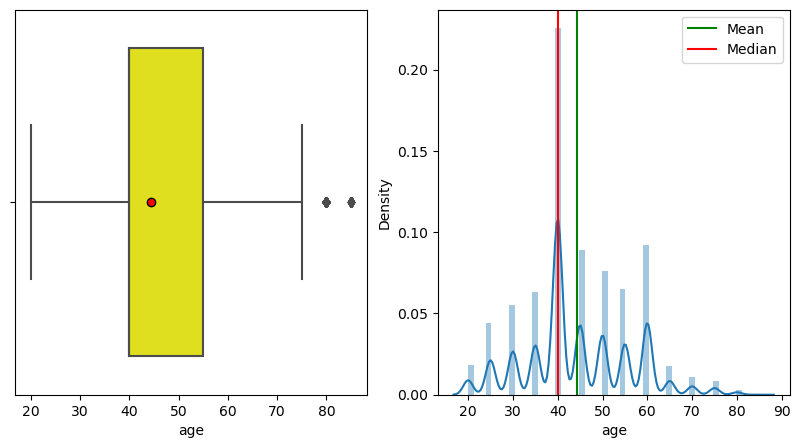

Skew -0.27


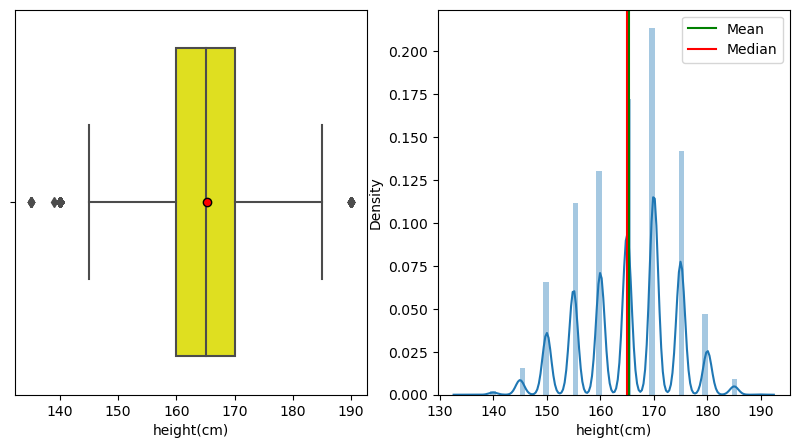

Skew 0.38


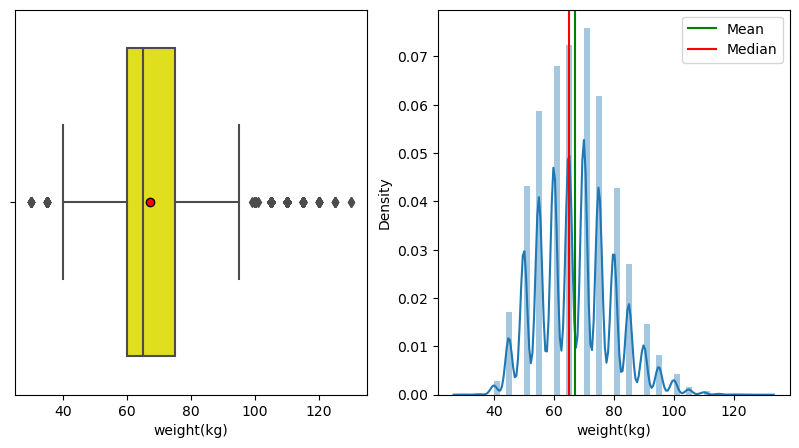

Skew 0.07


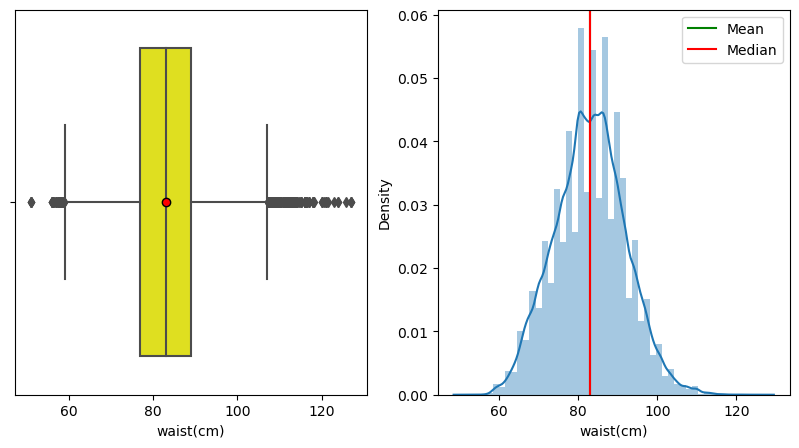

Skew 8.89


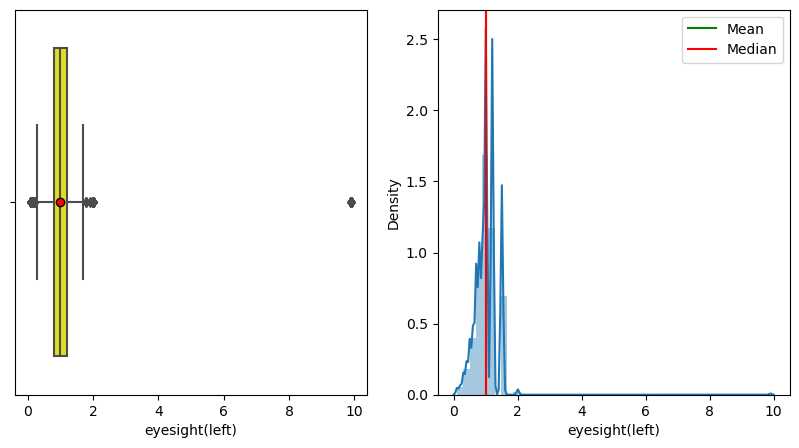

Skew 8.49


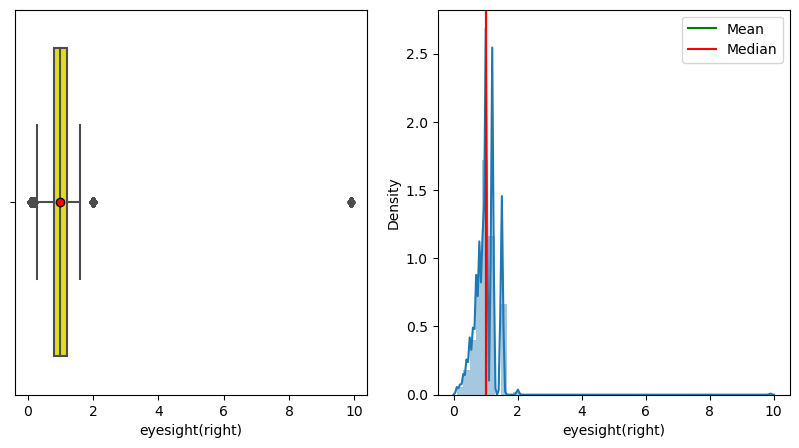

Skew 0.22


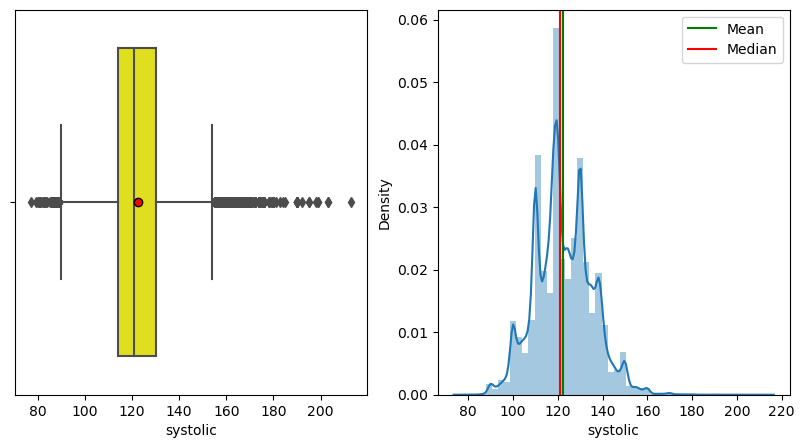

Skew 0.18


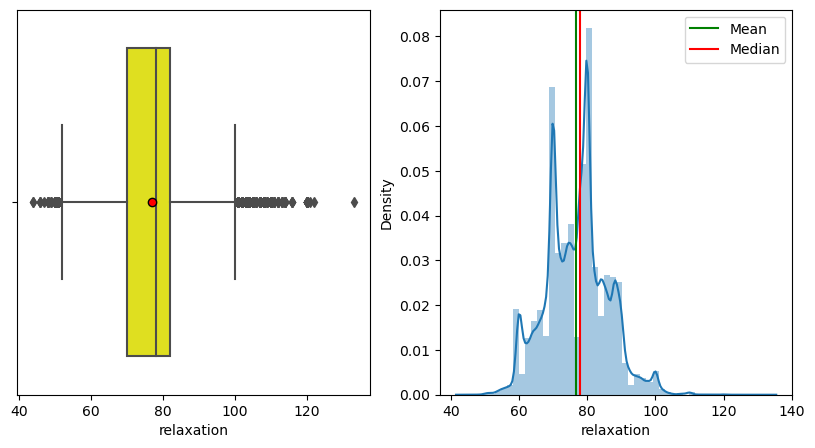

Skew 3.46


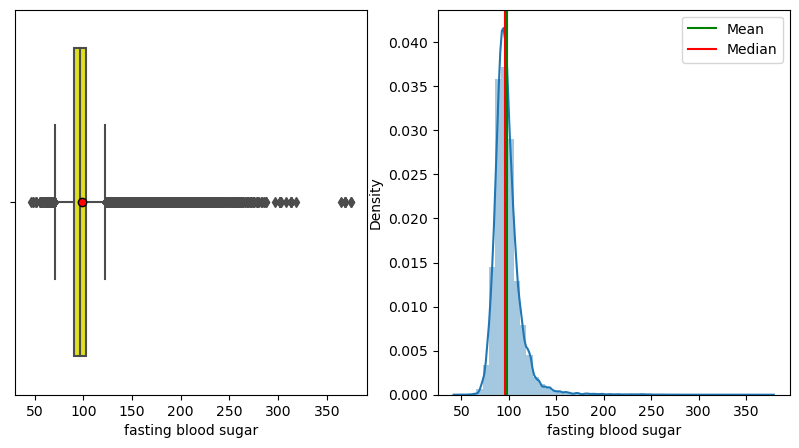

Skew 0.04


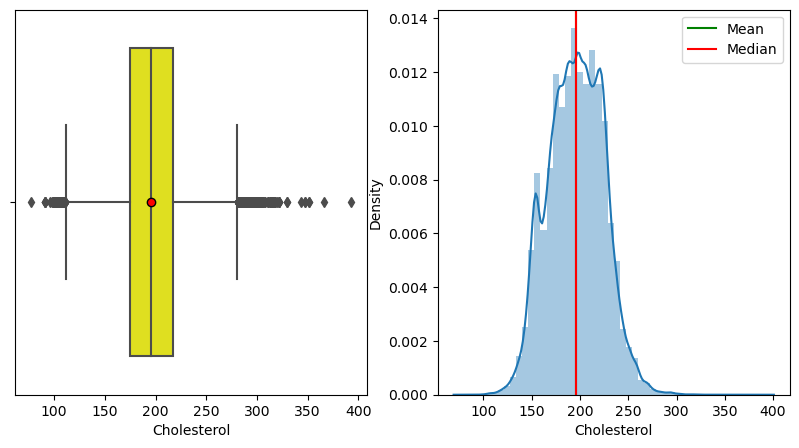

Skew 0.99


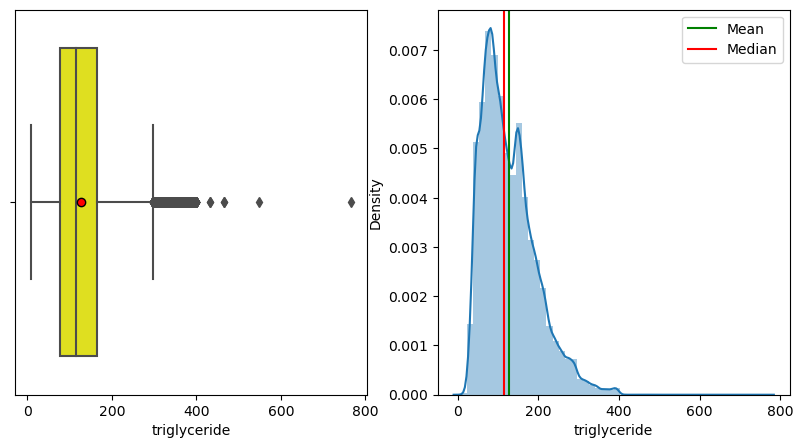

Skew 0.76


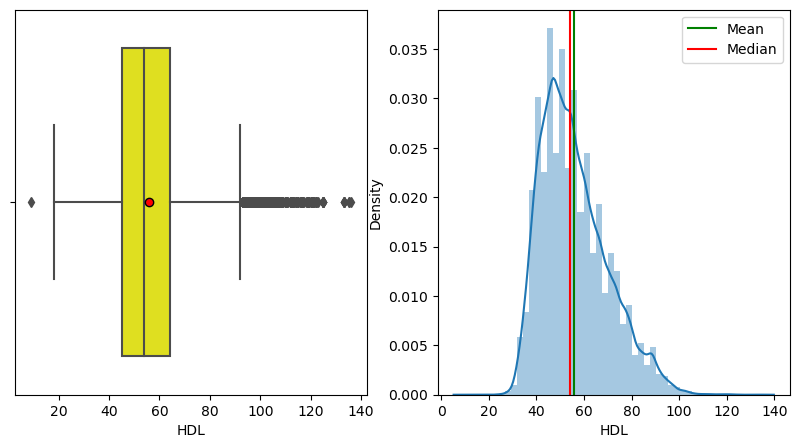

Skew 6.87


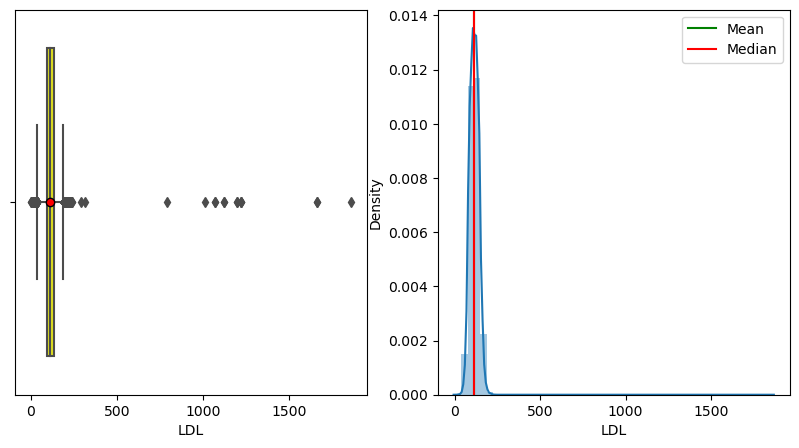

Skew -0.63


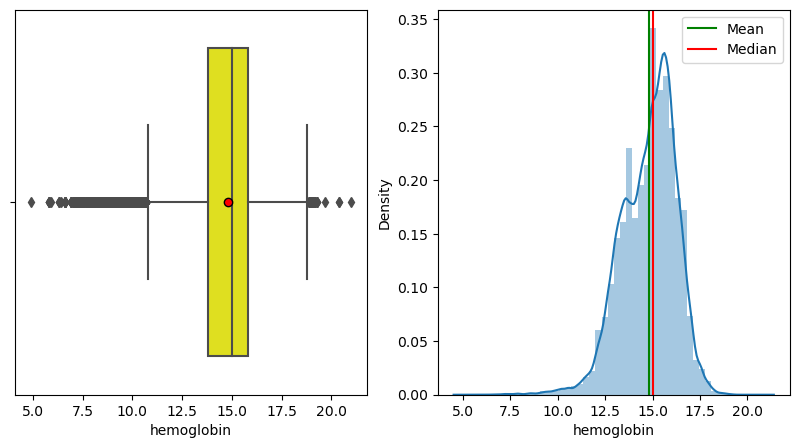

Skew 1.51


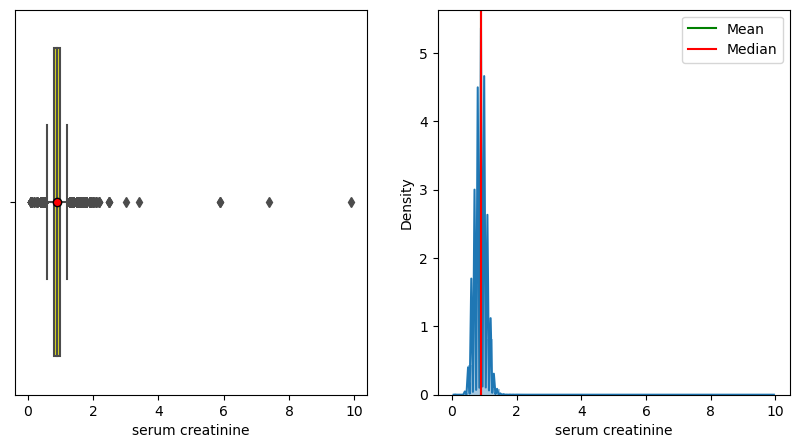

Skew 11.59


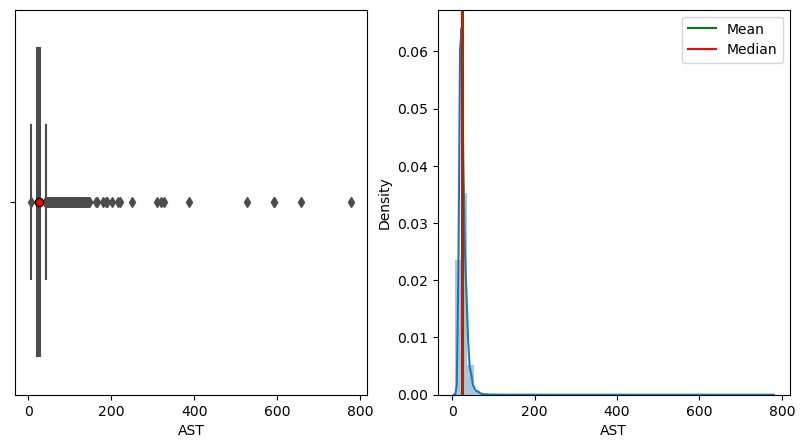

Skew 34.83


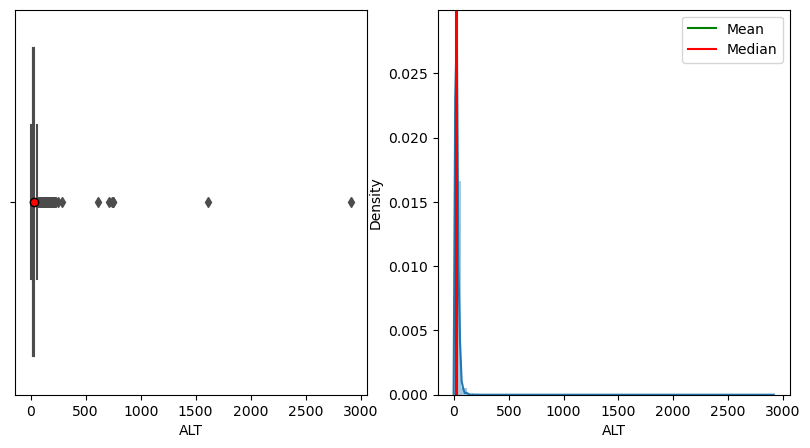

Skew 5.41


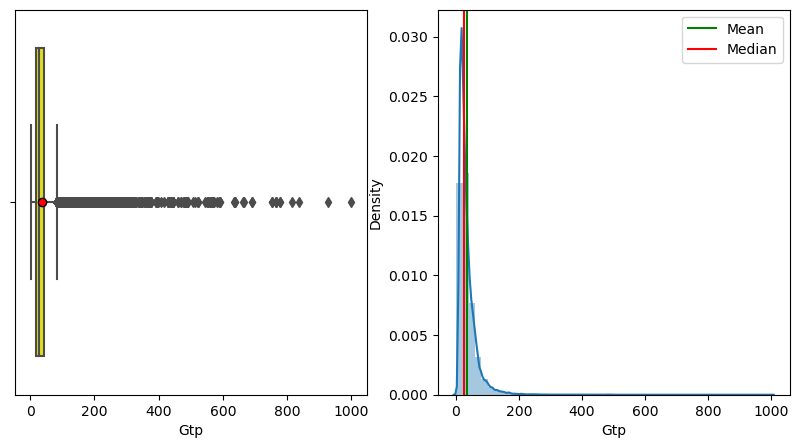

In [18]:
plot_viz(df, var_cont)

#### Observation : 
Pour les courbes de distributions :
- Skew ~ 0 : courbe qui suit une loi normale
- Skew > 0 : asymétrie vers la droite (queue étalée à droite)
- Skew < 0 : asymétrie vers la gauche (queue étalée à gauche)

* Plusieurs features présentent des skew proche de 0, ce qui signifie une symétrie de la courbe.
* A l'inverse, des features comme eyesight(left),eyesight(right), LDL, AST, ALT, Gtp, etc.. présentent beaucoup d'outliers (visualisable sur les boxplot) 
- Le manque d'information sur le descriptif n'aide pas à savoir quelle unité de mesure a été utilisé pour mesurer ces différentes concentrations (mL, UI,..) 

- Dans un premier temps, nous allons garder toutes les valeurs sans supprimer les valeurs. Il est possible que l'état d'une personne entre un fumeur et non fumeur influence enormement les différentes concentrations relevées sur les caractéristiques physico-chimique d'un individu.

Nous allons créer une fonction qui, pour une colonne donnée, supprimera les outliers. Cette fonction sera utilisé si on jugera ultérieurement que la présence d'outliers nous empêche de créer un bon modèle prédictif.

In [19]:
def clear_outliers(column, dataframe):
    """Fonction capable de supprimer une colonne sur le dataframe mis en paramètre"""
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1    #IQR = valeur interquartile 
    filt = (dataframe[column] >= Q1 - 1.5 * IQR) & (dataframe[column] <= Q3 + 1.5 *IQR)
    dataframe = dataframe.loc[filt]  
    return dataframe #Recuperation du dataframe apres suppression des outliers

#Ex d'utilisation : suppression valeurs aberrantes pour la colonne "Gtp"
# df = clear_outliers("Gtp",df)

## 4. Analyse bivariée 
#### Analyse target Vs variables discrètes  : test du khi2
* Nous allons créer une fonction qui permet d'effectuer un test Chi² entre deux variables

In [20]:
def khi2(data, target, var_qualitative):
    # Test de Student pour comparer les moyennes des autres variables
    df_temp = pd.crosstab(data[target], data[var_qualitative])
    p_val = chi2_contingency(df_temp)[1]
    alpha = 0.05
    
    print(f"Test khi2 :  \n{var_qualitative} \np-value = {p_val.round(3)}")

    if p_val < alpha:
        print("p-value ≤ α , il y a une différence/corrélation entre les populations.")
    else:
        print("p-value ≥ α , il n’y a pas de différence/relation entre les populations de l’étude.")
        #Si c'est cette condition qui ait rempli, alors la variable ne sera pas conservée et sera supprimée
        return  var_qualitative

In [21]:
#Appliquons notre fonction sur l'ensemble de nos variables discrètes : 
var_a_suppr = [khi2(df, target.name, i) for i in var_cat]
var_a_suppr = [var for var in var_a_suppr if var is not None]  # Filtrer les valeurs None
var_a_suppr

[]

Les resultats montrent qu'aucune variables n'est à supprimer, et qu'elles influencent toutes de manière significative la target. Nous conserverons l'entièreté des variables discrètes.

#### Analyse target Vs variables continues  : Boxplot
- Nous allons réutiliser notre fonction que l'on va légèrement modifier afin d'afficher les boxplot des variables continues en fonction de la target

In [22]:
def plot_viz_2(dataframe, columns):
    for i in columns:
        fig,axes = plt.subplots(3,5, figsize=(10,5))

        sns.boxplot(y = i, ax=axes[0],data=dataframe,
                         showmeans=True, color = "yellow",
                         orient="v",
                         meanprops={"marker":"o","markerfacecolor":"red",
                                    "markeredgecolor":"black"} )
        
#         sns.displot(data=dataframe, x = i, hue = "smoking", kde = True, edgecolor = "black", ax = axes[0])
#         axes[1].axvline(dataframe[i].mean(), c = "green", label = "Mean")
#         axes[1].axvline(dataframe[i].median(), c = "red", label = "Median")
#         axes[1].legend()
        print("Skew", df[i].skew().round(2))
        plt.show()

{'age': 0.29,
 'height(cm)': -0.27,
 'weight(kg)': 0.38,
 'waist(cm)': 0.07,
 'eyesight(left)': 8.89,
 'eyesight(right)': 8.49,
 'systolic': 0.22,
 'relaxation': 0.18,
 'fasting blood sugar': 3.46,
 'Cholesterol': 0.04,
 'triglyceride': 0.99,
 'HDL': 0.76,
 'LDL': 6.87,
 'hemoglobin': -0.63,
 'serum creatinine': 1.51,
 'AST': 11.59,
 'ALT': 34.83,
 'Gtp': 5.41}

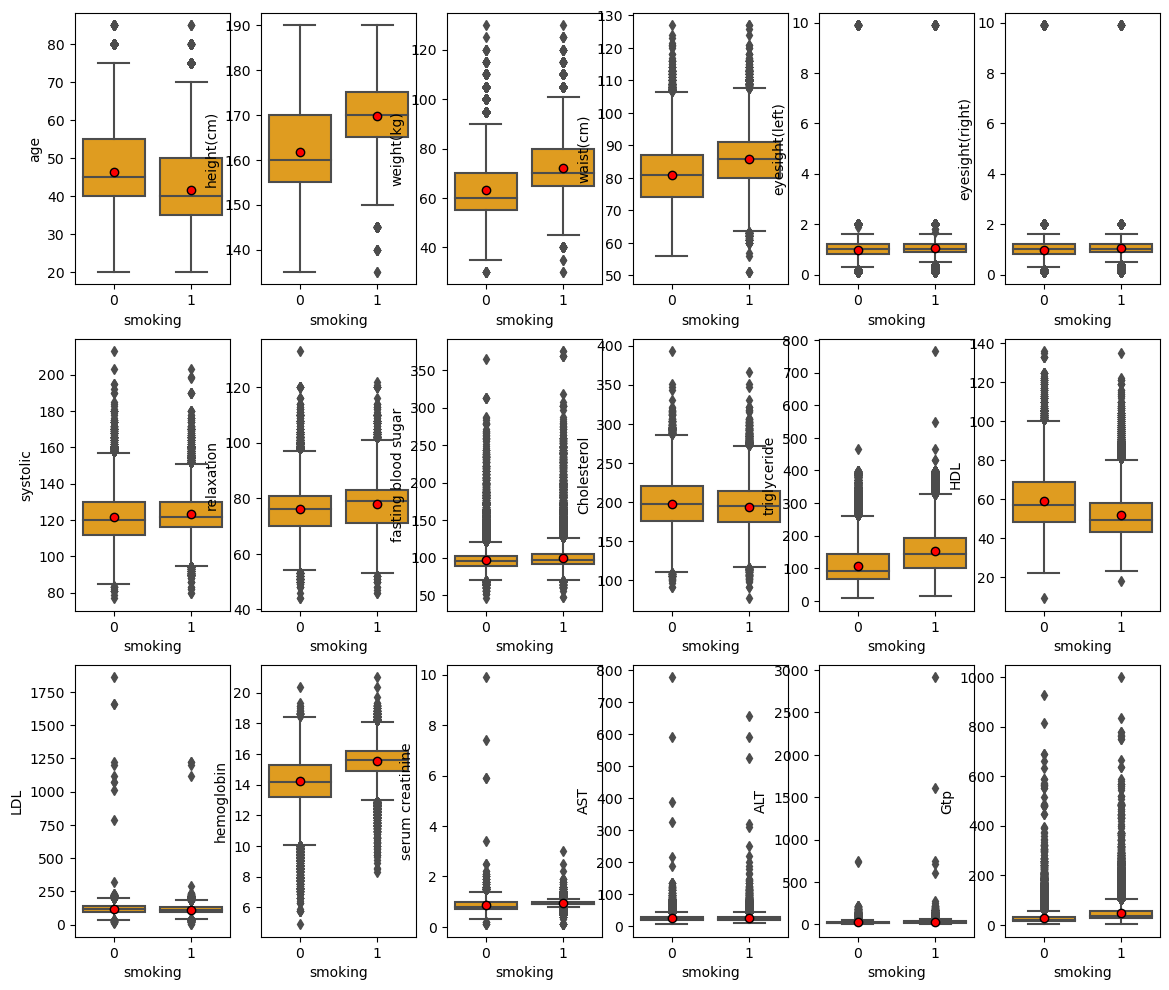

In [23]:
skew_dict = {}
fig,axes = plt.subplots(3,6, figsize=(14,12))
for i,col in enumerate(var_cont):
    nrow = i//6
    ncol = i%6
    sns.boxplot(y = col,  x = "smoking", 
                ax=axes[nrow,ncol],data=df,
                showmeans=True, 
                color = "orange",
                meanprops={"marker":"o","markerfacecolor":"red","markeredgecolor":"black"})
    skew_dict[col] = df[col].skew().round(2)
skew_dict

#### Observation : 
- Graphiquement, on peut voir des variations de la médiane des boxplot en fonction du type d'individus (fumeur vs non fumeur) pour une grande partie des features. 
- Les features pour lesquelles on voit très peu de variation de la médiane, ont de forte chance de ne pas être dépendante de la target. Par exemple les features eyesight ne présentent aucune variation entre l'individu fumeur et non fumeur, il y a donc de forte chance que cette feature ne soit pas dépendante de la target, et donc on pourra s'en débarasser.


- Nous allons utiliser des tests statistiques pour voir s'il existe une corrélation entre la target et chaque features :
    - Pour les features suivant une loi normale + égalité des variances : on utilisera le **test student** (et non ANOVA car ici la target smoking ne prend que 2 valeurs)
    - Pour les features ne suivant pas une loi normale : utilisation du **test de corrélation de Mann Whitney**

In [127]:
### Fonction pour vérifier si une variable suit une loi normale : 
def shapiro_test(list_col, dataframe, mode = "normal"):
    """
    Fonction shapiro test qui renvoi une liste d'élément
    
    """
    if type(list_col) == str:
        list_col = [list_col]
    
    var_normal = []
    var_non_normal = []
    
    # Test de normalité de Shapiro-Wilk
    for i in list_col:
        statistic, p_value = shapiro(dataframe[i])
        print("feature :", i)
    
        # Afficher les résultats
        print(f"Statistique de test W : {round(statistic,2)}")
        print(f"P-value : {p_value}")
    
    # Interpréter les résultats
        alpha = 0.05  # Niveau de signification
    
        if p_value < alpha:
#             print("Les données ne suivent probablement pas une distribution normale.")
            var_non_normal.append(i)
        else:
#             print("Les données semblent suivre une distribution normale.")
            var_normal.append(i)
        print()    
    
    print("Features suivant une loi normale :", var_normal)
    print("Features ne suivant pas une loi normale :", var_non_normal)
    
    if mode == "normal":
        return var_normal
    elif mode == "non_normal":
        return var_non_normal
    elif mode == "all":
        return var_normal, var_non_normal
    else:
        return "Veuillez précisez un mode 'normal', non_normal' ou 'all'"

In [134]:
var_non_normal = shapiro_test(list_col=var_cont, dataframe=df, mode="non_normal")

feature : age
Statistique de test W : 0.96
P-value : 0.0

feature : height(cm)
Statistique de test W : 0.96
P-value : 0.0

feature : weight(kg)
Statistique de test W : 0.97
P-value : 0.0

feature : waist(cm)
Statistique de test W : 1.0
P-value : 1.9092178140668304e-36

feature : eyesight(left)
Statistique de test W : 0.66
P-value : 0.0

feature : eyesight(right)
Statistique de test W : 0.68
P-value : 0.0

feature : systolic
Statistique de test W : 0.99
P-value : 0.0

feature : relaxation
Statistique de test W : 0.99
P-value : 0.0

feature : fasting blood sugar
Statistique de test W : 0.78
P-value : 0.0

feature : Cholesterol
Statistique de test W : 1.0
P-value : 0.0

feature : triglyceride
Statistique de test W : 0.94
P-value : 0.0

feature : HDL
Statistique de test W : 0.96
P-value : 0.0

feature : LDL
Statistique de test W : 0.87
P-value : 0.0

feature : hemoglobin
Statistique de test W : 0.98
P-value : 0.0

feature : serum creatinine
Statistique de test W : 0.94
P-value : 0.0

featu

Aucune features ne suit de loi normal, donc nous allons faire un **test de mann whitney**

- On peut aussi faire un test de levene pour voir si les variances sont égales ou non :

In [158]:
#Fonction pour vérifier une égalité des variance entre  deux variables : 

def levene_test(feature,target, dataframe):
    variance_differente = []
    variance_egales = []
    
    """Fonction qui permet d'effectuer le test Levene
    feature : liste de features ou une feature unique
    target : str : le nom de la target
    dataframe : le jeu de données
    renvoi un tuple contenant la liste des features ayant des variances égales 
    puis celle ayant des variances différentes"""
    
    #Test si la feature est une liste ou simplement une feature
    if type(feature) == str:
        feature = [feature]
    
    for i in feature:
           # Test de Levene
        statistic, p_value = levene(dataframe[i],dataframe[target])

        # Afficher les résultats
        print(f"Statistique de test : {statistic}")
        print(f"P-value : {p_value}")
        

        # Interpréter les résultats
        alpha = 0.05  # Niveau de signification
        if p_value < alpha:
            variance_differente.append(i)
    #         print("Les variances des échantillons sont différentes.")
        else:
            variance_egales.append(i)
    #         print("Les variances des échantillons sont probablement égales.")
        print()
    
    print("features avec une égalité de variance :", variance_egales)
    print("features avec une différence de variance :", variance_differente)
    return variance_egales, variance_differente

In [156]:
levene_test(feature=var_cont,target="smoking", dataframe=df)

Statistique de test : 168449.37322531483
P-value : 0.0

Statistique de test : 266212.31859952764
P-value : 0.0

Statistique de test : 244297.97744355586
P-value : 0.0

Statistique de test : 244001.0225930091
P-value : 0.0

Statistique de test : 17180.50121566097
P-value : 0.0

Statistique de test : 17984.325110757265
P-value : 0.0

Statistique de test : 247335.30414962815
P-value : 0.0

Statistique de test : 230779.35386655683
P-value : 0.0

Statistique de test : 91972.41044376977
P-value : 0.0

Statistique de test : 307445.14200854866
P-value : 0.0

Statistique de test : 230492.6884918146
P-value : 0.0

Statistique de test : 233100.57284722044
P-value : 0.0

Statistique de test : 207779.4855485811
P-value : 0.0

Statistique de test : 74468.82048777322
P-value : 0.0

Statistique de test : 55279.88773997541
P-value : 0.0

Statistique de test : 88671.75132097311
P-value : 0.0

Statistique de test : 70011.90838721818
P-value : 0.0

Statistique de test : 65498.102899189216
P-value : 0.0

f

#### Aucunes variable n'a de variance égale avec la target

#### Test Man-Whitney : 

In [177]:

def manwhitney(feature, target, dataframe):
    var_a_conserver = []
    var_a_supprimer = []

    """Fonction qui permet d'effectuer le test de Man Whitney
    feature : liste de features ou une feature unique
    target : str : le nom de la target
    dataframe : le jeu de données
    renvoi un tuple contenant la liste des features ayant des variances égales 
    puis celle ayant des variances différentes"""

    #Test si la feature est une liste ou simplement une feature
    if type(feature) == str:
        feature = [feature]
    
    for i in feature:
           # Test de Levene
        statistic, p_value = mannwhitneyu(dataframe[i],dataframe[target])

        # Afficher les résultats
        print(f"Statistique de test : {statistic}")
        print(f"P-value : {p_value}")

        # Interpréter les résultats
        alpha = 0.05  # Niveau de signification
        if p_value < alpha:
#             print("Les échantillons proviennent de distributions différentes (rejeter l'hypothèse nulle).")
            var_a_conserver.append(i)
        else:
#             print("Les échantillons proviennent probablement de la même distribution (ne pas rejeter l'hypothèse nulle).")
            var_a_supprimer.append(i)
        print()
    print("features a supprimer :", var_a_supprimer)
    print("features a conserver :", var_a_conserver)
    return var_a_conserver, var_a_supprimer

In [178]:
manwhitney(feature=var_cont,target="smoking", dataframe=df)

Statistique de test : 25362473536.0
P-value : 0.0

Statistique de test : 25362473536.0
P-value : 0.0

Statistique de test : 25362473536.0
P-value : 0.0

Statistique de test : 25362473536.0
P-value : 0.0

Statistique de test : 19673495108.0
P-value : 0.0

Statistique de test : 19619096115.0
P-value : 0.0

Statistique de test : 25362473536.0
P-value : 0.0

Statistique de test : 25362473536.0
P-value : 0.0

Statistique de test : 25362473536.0
P-value : 0.0

Statistique de test : 25362473536.0
P-value : 0.0

Statistique de test : 25362473536.0
P-value : 0.0

Statistique de test : 25362473536.0
P-value : 0.0

Statistique de test : 25362403883.0
P-value : 0.0

Statistique de test : 25362473536.0
P-value : 0.0

Statistique de test : 17343358472.5
P-value : 0.0

Statistique de test : 25362473536.0
P-value : 0.0

Statistique de test : 25362369056.5
P-value : 0.0

Statistique de test : 25362473536.0
P-value : 0.0

features a supprimer : []
features a conserver : ['age', 'height(cm)', 'weight(kg)

(['age',
  'height(cm)',
  'weight(kg)',
  'waist(cm)',
  'eyesight(left)',
  'eyesight(right)',
  'systolic',
  'relaxation',
  'fasting blood sugar',
  'Cholesterol',
  'triglyceride',
  'HDL',
  'LDL',
  'hemoglobin',
  'serum creatinine',
  'AST',
  'ALT',
  'Gtp'],
 [])

#### ici toutes les variables influencent la target, donc nous allons conserver l'entièreté des features pour la modélisation 

### 5. Analyse multivariée 

- Nous allons observer les différentes features et voir ce qu'on peut en déduire 

####  Corrélation linéaire avec une heatmap 

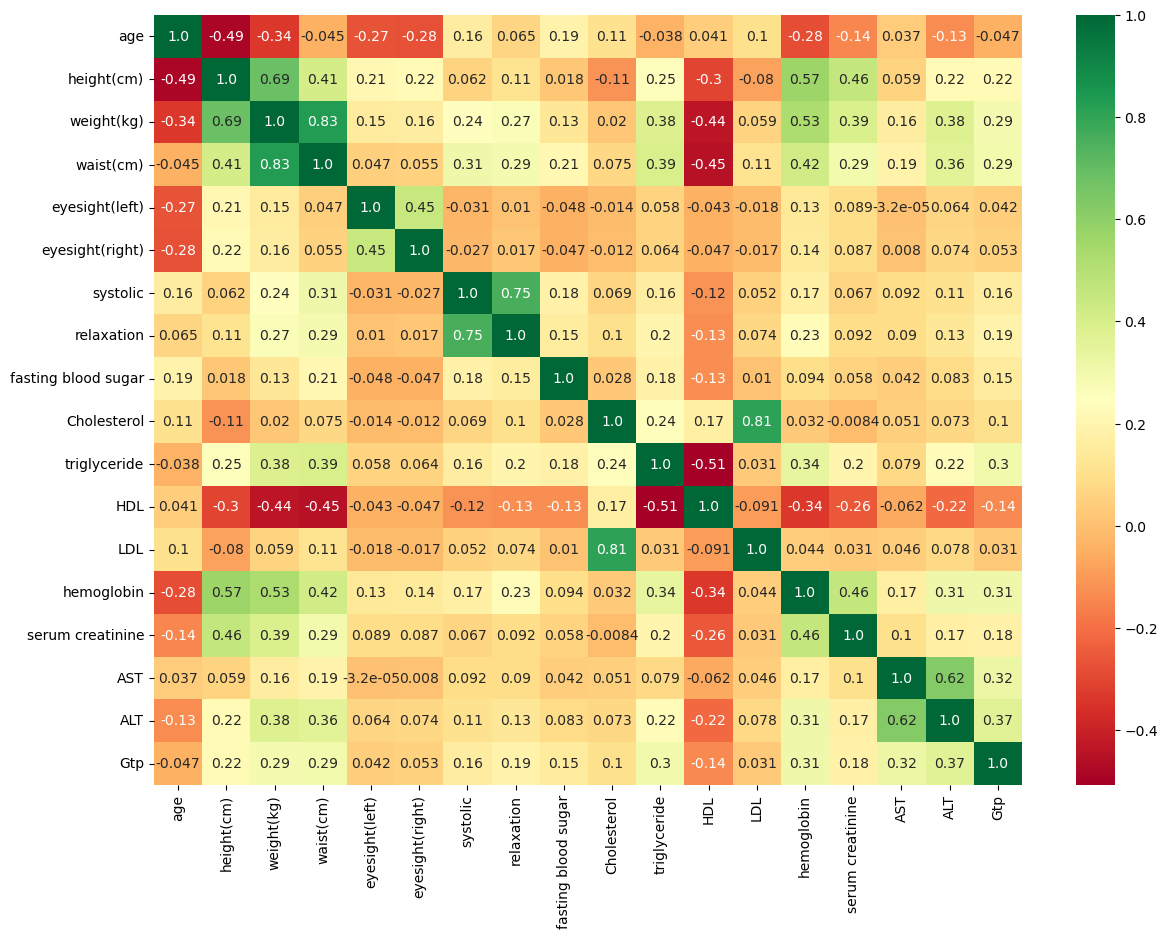

In [200]:
plt.figure(figsize=(14,10))
sns.heatmap(data = df[var_cont].corr(),cmap = "RdYlGn",  annot = True, fmt = ".2", linecolor="black")
plt.show()

#### Observation : 
Nous pouvons observer plusieurs corrélation et anticorrélation linéaire sur les différentes features continues : 
- Les variables corrélées : 
    - height(cm) - weight(kg)
    - weight(kg) - waist(cm)
    - eyesight(left) - eyesight(right)
    - Cholesterol - LDL
    - systolic - relaxation
    - hemoglobine - height(cm), weight(kg), waist(cm)
    - AST - ALT
- variables anticorrélées : 
    - age - height(cm), weight(kg), eyesight(left)  eyesight(right)
    - weight(kg) - HDL
    - waist(cm) - HDL
    - triglyceride - HDL

Plusieurs explications peuvent être données pour justifier ces différents résultats : 
- Pour les variables corrélées, on comprend facilement que plus une personne est grande et plus sa masse est élevée. Plus une personne pèse lourd et plus son tour de ventre est élevé. La vue va en général de paire. Le cholesterol et le LDL augmente de façon conjointe, etc.
- Pour les variables anticorrélées : plus l'âge est élevée et plus la personne est petite (on comprend que la taille moyenne des individus à augmenter depuis ces dernières années); la vue diminue avec l'âge, de même pour le poids (surtout si une personne est de plus petite taille, logiquement son poids l'est aussi). etc.

#### Scatterplot :
- Regardons quelques relation entre les variables, en rajoutant la target : 

In [264]:
def scatter(x,y,nrow,ncol):
    """fonction qui permet de tracer un scatterplot  sur le dataframe df avec smoking en hue
    x: variable en x
    y: variable en y
    """
#     plt.figure(figsize=(6,5))
    sns.scatterplot(x=x, y=y, data = df, ax = axes[nrow,ncol], hue = "smoking")
#     plt.suptitle(f"Analyse de {x} en fonction de {y}")


#### Variables corrélées : 

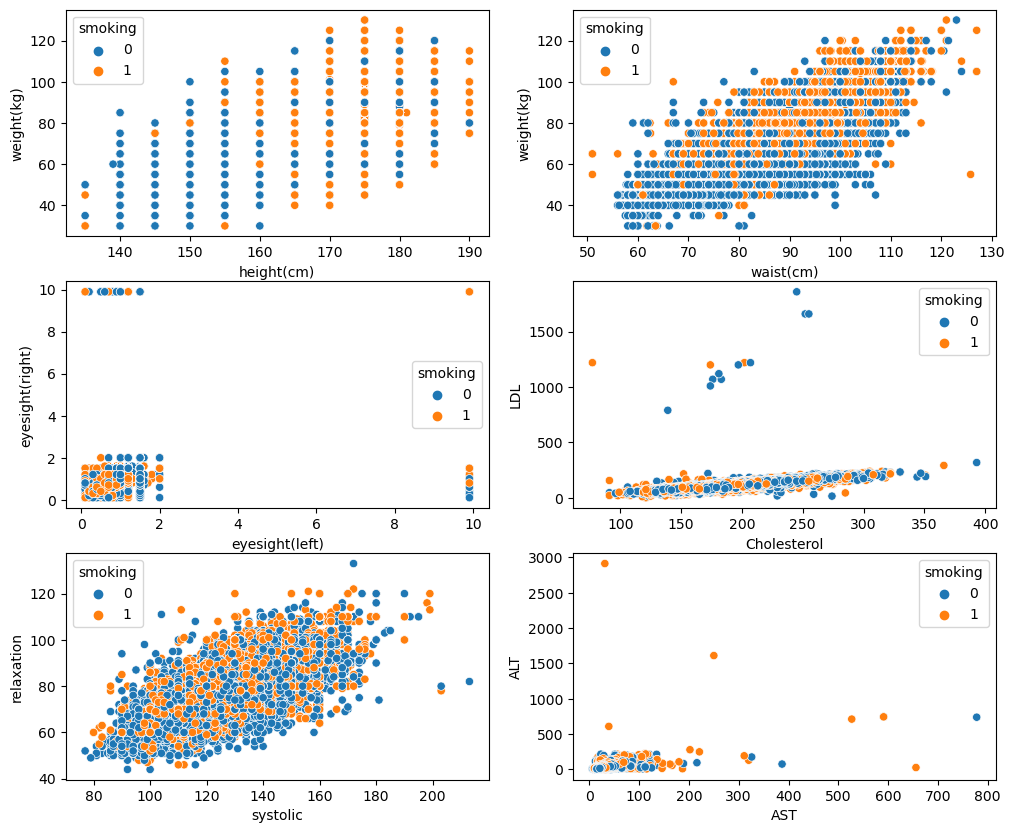

In [276]:
fig,axes = plt.subplots(3,2,figsize=(12,10))
scatter(x="height(cm)" , y= "weight(kg)", nrow=0,ncol= 0)
scatter(x="waist(cm)" , y= "weight(kg)",  nrow=0,ncol= 1)
scatter(x="eyesight(left)",y="eyesight(right)", nrow=1 , ncol= 0)
scatter("Cholesterol", "LDL" , nrow=1 , ncol= 1)
scatter('systolic','relaxation', nrow=2 , ncol= 0)
scatter('AST','ALT', nrow=2 , ncol= 1)


### Observation : 

#### height(cm) weight(kg)
- Si on regarde en fonction du poids, la plupart des fumeurs ont des tailles et poids plus élevés
    - On peut emettre l'hypothèse suivante : en général, les hommes sont plus grands (et plus lourds) que les femmes, et donc on peut supposer ici que les fumeurs sont plus souvent des hommes que des femmes
    
#### weight(kg)  waist(cm) 
- Encore une fois ici, plus on est lourd et plus le tour de taille augmente, et la plupart des fumeurs sont des individus avec des valeurs en (x,y) élevées, et on peut arriver à la même interprétation évoqué précédemment

#### eyesight(left) eyesight(right)
- La majorité des indivius ont une vue autour de 2, fumeur ou non.

#### Cholesterol LdL
- Ici il n'y a pas trop de distinction à faire entre les individus fumeur et non ufmeur
#### systolic relaxation
- Les données ici aussi sont assez homogènes et il n'y a pas vraiment de cohorte qui se dégage entre les fumeurs et non fumeurs
#### AST ALT 
- on peut voir ici que seul les fumeurs se retrouvent avec des valeurs AST ou ALT bien plus élevées que les non fumeurs à quelques exceptions prêtes


#### Regardons avec les variables corrélées à la variable hemoglobin :

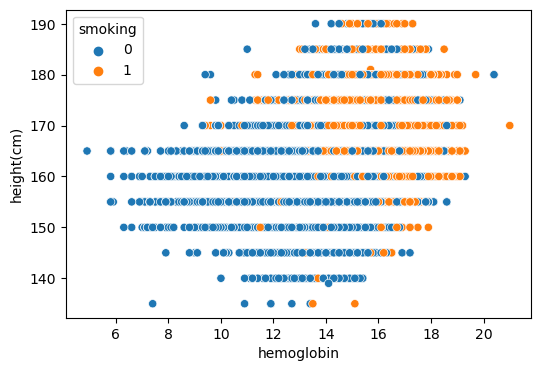

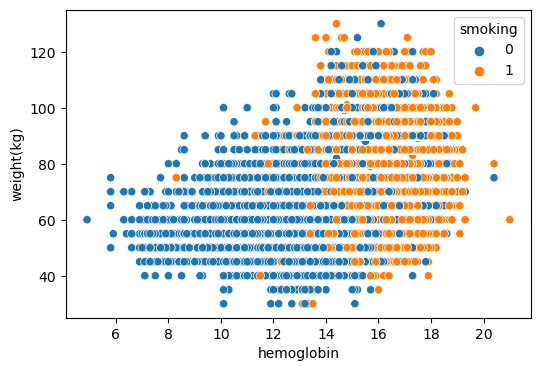

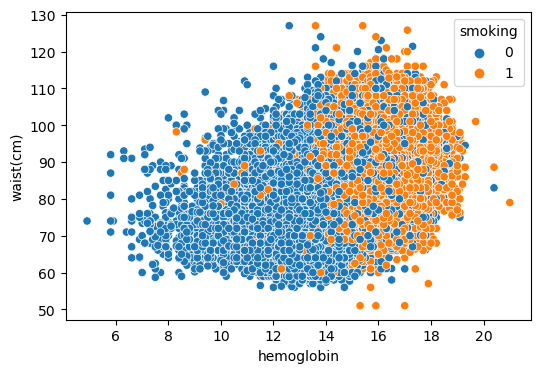

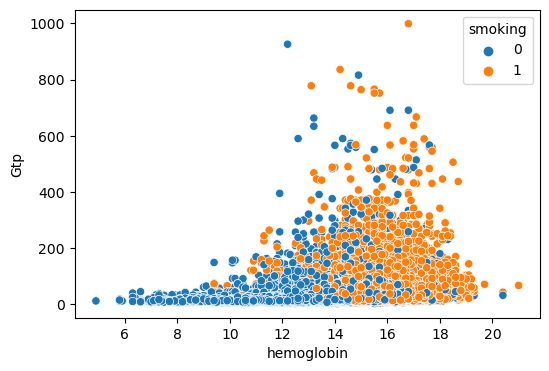

In [317]:
for i,col in enumerate(['height(cm)', 'weight(kg)', 'waist(cm)','Gtp']):
    plt.figure(figsize=(6,4))
    sns.scatterplot(x="hemoglobin",y = col, data = df, hue = "smoking")
    plt.show()
 

#### Observation : 
- Ici il apparaît plus clairement qu'avec la feature **hemoglobin**, on arrive a mieux séparé les fumeurs des non fumeurs, on remarque que les fumeurs ont tendance à avoir une valeur plus élevées que les non fumeurs. **On peut dire ici que cette feature est importante pour pouvoir différencier les fumeurs des non fumeurs**

### Variables anti-corrélées :
- Voyons maintenant les variables anti corrélées : 

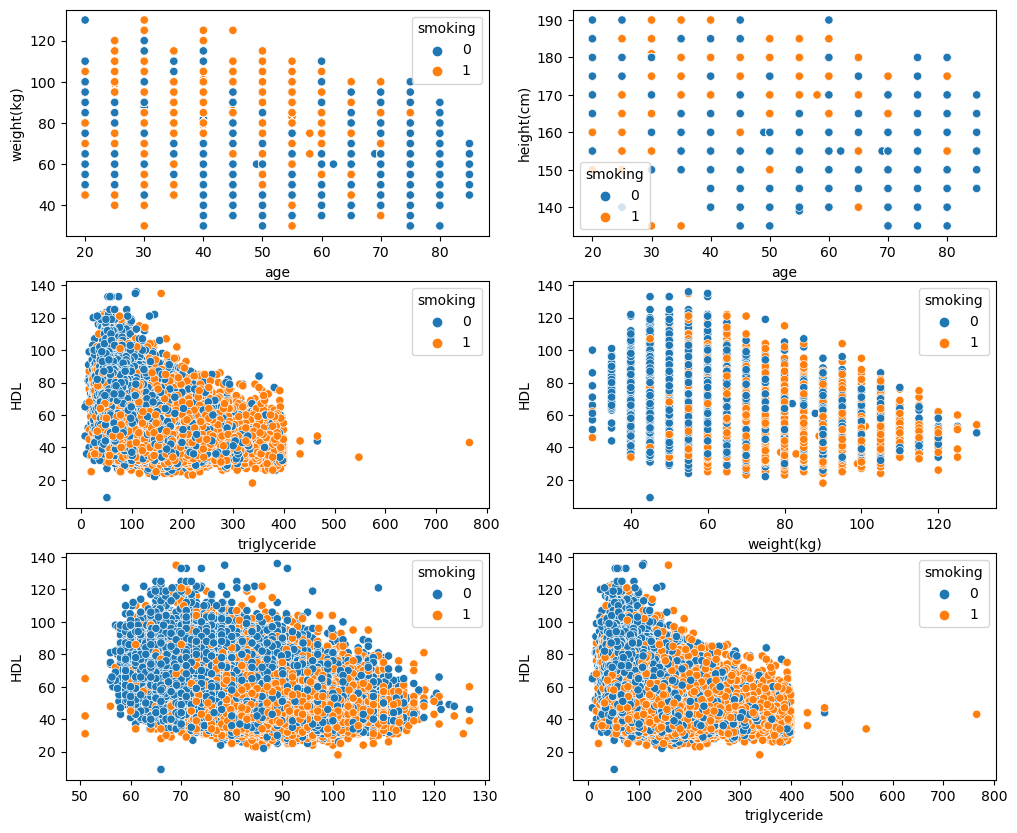

In [274]:
fig,axes = plt.subplots(3,2,figsize=(12,10))
scatter(x="age" , y= "weight(kg)", nrow=0,ncol= 0)
scatter(x="age" , y= "height(cm)",  nrow=0,ncol= 1)
scatter(x="triglyceride",y="HDL", nrow=1 , ncol= 0)
scatter("weight(kg)", "HDL" , nrow=1 , ncol= 1)
scatter('waist(cm)','HDL', nrow=2 , ncol= 0)
scatter('triglyceride','HDL', nrow=2 , ncol= 1)

### Observation : 
#### weight(kg) age
- on peut voir une légère anticorrélation,  avec une légère tendance pour des individus fumeurs ayant des poids plus élevées, à partir de 70 ans on retrouve plus de non fumeur que de fumeur

#### height(cm) age
- ici le graphique est beaucoup moins pertinent et plus difficilement exploitable
#### triglyceride HDL :
- On voit deux groupes qui se degage un peu plus clairement, entre les patients fumeurs avec des valeurs en triglyceride bien plus élevées en moyenne, et des valeurs HDL plus basse. Les non fumeurs eux ont des valeurs HDL plus élevées et moins de tryglyceride

#### HDL weight(kg)
- les fumeurs se trouvent surtout du côté des individus ayant des poids plus élevés, peu importe la quantité HDL on retrouve des fumeurs qui s'étale sur l'ensemble des valeur HDL

#### HDL waist(cm)
- Ici aussi on peut voir que la majorité des non fumeurs ont des valeurs plus faible en HDL mais des valeurs élevées en waist contrairement aux non fumeurs
#### HDL triglyceride
- les fumeurs ont des valeurs élevées en triglyceride et faible en HDL tandis que les non fumeurs ont des valeurs élevées en HDL


## 6. PCA
- Preparation des données pour la PCA : séparation des données pour la standardisation des variables continues

In [508]:
#Séparation des données
# df_cont = df[var_cont]
X,y = df.drop("smoking", axis = 1), df.smoking
var_dis = [i for i in var_dis if i!= y.name]

X_train, X_test,y_train,y_test = train_test_split(X,y, random_state=42, test_size=0.2 )

#Standardisation
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[var_cont]), index=  X_train.index, columns=X[var_cont].columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test[var_cont]), index=X_test.index, columns=X[var_cont].columns)
#Concaténation :
X_scaled = pd.concat([X_train_scaled, X_test_scaled])

In [509]:
pca = PCA(n_components=0.9, random_state=42)
X_pca = pca.fit_transform(X_scaled)

In [510]:
sse = (pca.explained_variance_ratio_*100).round(2)
n = [i for i in range(len(sse))]

sse_cum = np.cumsum(sse)
sse_cum

array([24.9 , 37.5 , 46.92, 55.  , 62.5 , 68.51, 73.47, 77.98, 82.3 ,
       85.78, 88.87, 91.72])

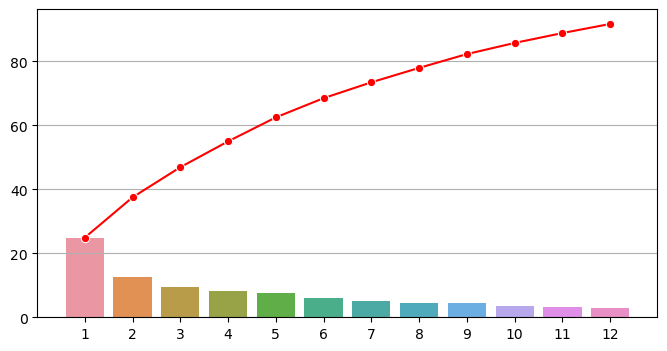

In [511]:
plt.figure(figsize=(8,4))
plt.grid()
sns.barplot(x = [i+1 for i in n], y = sse)
ax = sns.lineplot(x = n, y = sse_cum, color = "red", style = True, marker = "o")
ax.get_legend().remove()
plt.show()

In [512]:
print(f"On passe de {df_cont.shape[1]} variables à {len(n)} variables soit une diminution de {df_cont.shape[1]-len(n)} ")

On passe de 18 variables à 12 variables soit une diminution de 6 


In [513]:
pcs = pd.DataFrame(pca.components_, columns=X_scaled.columns)
pcs.index = [f"F{i+1}" for i in pcs.index]

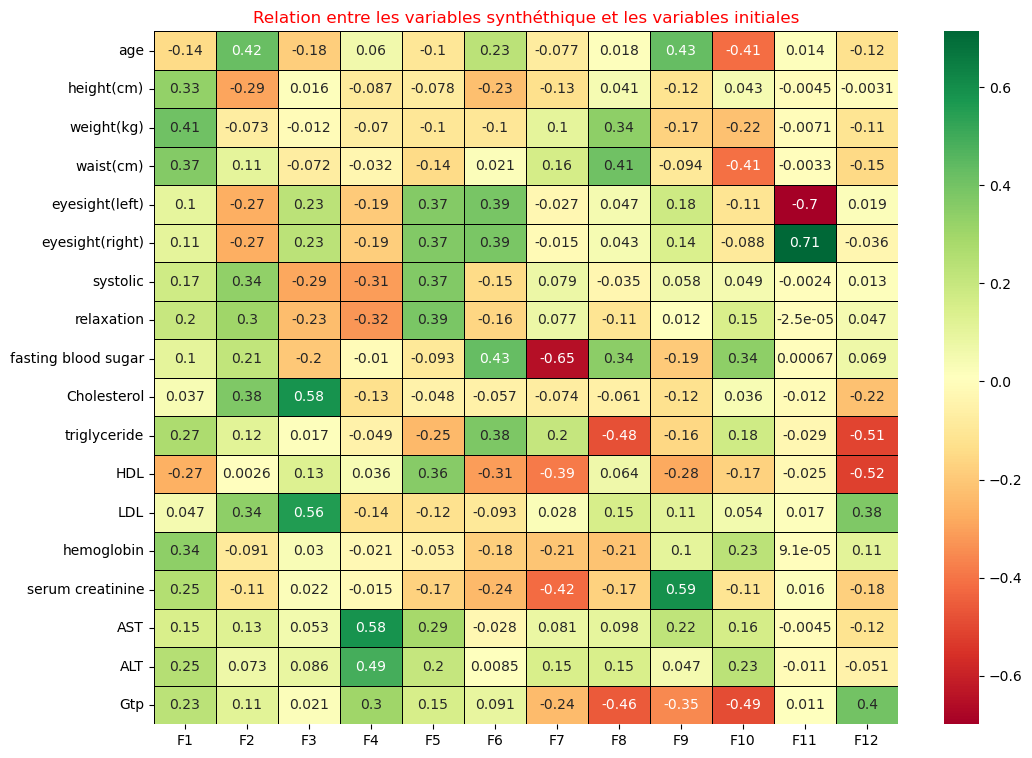

In [514]:
plt.figure(figsize=(12,9))
plt.title("Relation entre les variables synthéthique et les variables initiales",fontdict={"color":"red"})
sns.heatmap(pcs.T, annot = True, linecolor="black", linewidths=0.5, cmap="RdYlGn")
plt.show()

### Observation : 
- La heatmap nous permet de voir les relations entre les variables initiales et les variables synthéthiques. 
    - Par exemple **F1** : est une combinaison des variables height(cm), weight(kg), waist(cm)  qui correspondent aux caractéristiques physique des individus
    - **F2** : à l'age
    - **F3**:  au cholesterol, au LDL donc surtout la composante lipidique
    - **F4** : aux enzymes AST et ALT
    etc.

- Nous pouvons utiliser les données réduites par PCA plutôt que de garder le jeu de données sans réduction de dimension, en étant conscient que simplifier le jeu de données aura pour conséquence une perte d'information. Cependant, cela peut faciliter l'apprentissage du modèle en **réduisant** le bruit et en supprimant des variables trop corrélées entre elles.

In [539]:
#Récupération des données réduites par PCA : 
df_reduced = pd.DataFrame(X_pca, columns= pcs.index)

#Concaténation des features X contenant les variables discrètes : 
X_dis = pd.concat([X_train[var_dis], X_test[var_dis]]) 

#Fusion entre les données réduites par PCA et les variables discrètes : 
new_df = pd.concat([df_reduced,X_dis], axis = 1) #Remplacez df_reduced par X_scaled si on ne veut pas utiliser les données PCA
new_df

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,hearing(left),hearing(right),Urine protein,dental caries
0,-3.606746,0.755803,-1.218238,-0.401488,-0.427850,-0.212524,0.734177,0.772676,-1.172399,0.307489,-0.006818,0.700179,1,1,1,0
1,-1.181505,4.401603,-2.490884,-1.117876,0.384461,3.960486,-6.225314,2.274480,-1.635772,3.977569,0.548055,1.063149,2,2,1,1
2,-2.731105,-1.048645,-0.828711,0.055921,0.090602,1.316630,1.122125,0.630216,0.379617,-0.711981,0.085530,0.998121,1,1,1,0
3,-1.369274,1.904712,0.788166,-1.374263,-0.530577,-0.646030,0.669578,0.086063,-0.155953,-0.352081,0.210692,0.889490,1,1,1,1
4,1.614225,-1.958460,-0.953814,-0.379936,0.165742,-0.792837,1.132931,1.293741,-0.738215,-0.599433,0.329744,-0.559030,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159251,-1.329665,-2.397252,-0.611504,0.649304,0.010029,-0.133459,1.021439,0.140257,-0.595010,0.891175,-1.777965,0.876836,1,1,1,0
159252,-1.080955,1.372029,-1.049631,-1.334421,2.707685,-0.724835,0.219782,0.401719,-1.455404,0.433076,-0.076129,-0.864527,1,1,1,0
159253,1.753716,-1.774391,-0.565254,0.418961,-1.238398,1.225304,-1.042233,-0.759241,0.263574,0.071404,0.045560,0.366918,1,1,1,0
159254,-3.024858,-2.569208,0.004010,0.810454,-0.672273,0.528006,0.109960,-1.293560,-0.500577,0.617035,0.002170,0.189470,1,1,1,0


## 7. preprocessing : encodage et standardisation des données
- lors de la PCA nous avoins déjà standardisé les données
- Pour l'encodage, les variables sont déjà au format **binaire** donc pas besoin d'effectuer d'actions supplémentaire

In [551]:
final_df = pd.concat([new_df,y], axis = 1)
final_df.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,hearing(left),hearing(right),Urine protein,dental caries,smoking
0,-3.606746,0.755803,-1.218238,-0.401488,-0.427850,-0.212524,0.734177,0.772676,-1.172399,0.307489,-0.006818,0.700179,1,1,1,0,1
1,-1.181505,4.401603,-2.490884,-1.117876,0.384461,3.960486,-6.225314,2.274480,-1.635772,3.977569,0.548055,1.063149,2,2,1,1,0
2,-2.731105,-1.048645,-0.828711,0.055921,0.090602,1.316630,1.122125,0.630216,0.379617,-0.711981,0.085530,0.998121,1,1,1,0,1
3,-1.369274,1.904712,0.788166,-1.374263,-0.530577,-0.646030,0.669578,0.086063,-0.155953,-0.352081,0.210692,0.889490,1,1,1,1,0
4,1.614225,-1.958460,-0.953814,-0.379936,0.165742,-0.792837,1.132931,1.293741,-0.738215,-0.599433,0.329744,-0.559030,1,1,1,0,1


### 8. Enregistrement du dataframe :

In [548]:
path_df = r"D:\\Etude_Data_science\\Kaggle_competition\\02_Binary_Prediction_of_Smoker_Status_using_Bio-Signals\\dataset\\"

In [549]:
final_df.to_csv(path_or_buf=path_df + "data_cleaned.csv")